In [14]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import json, os
import seaborn as sns   
import pandas as pd
import copy
from ipywidgets import interact, IntSlider, Select, HBox
from utilities import interpolate_volume
from dicom_tools import DicomToolbox

def apply_windowing(ct_scan, window_width, window_center):

    # Calculate the lower and upper bounds
    lower_bound = window_center - (window_width / 2)
    upper_bound = window_center + (window_width / 2)
    
    # Apply the windowing
    windowed_ct = np.clip(ct_scan, lower_bound, upper_bound)
    
    # Normalize the values to the range [0, 255]
    windowed_ct = ((windowed_ct - lower_bound) / (upper_bound - lower_bound)) * 255.0
    windowed_ct = windowed_ct.astype(np.uint8)
    
    return windowed_ct

def resize_to_user_resolution(volume, in_coords, voxel_dimensions, coord_precision = 4, fill_value = 0):
    
    coords = copy.deepcopy(in_coords) # make a copy of the coordinates

    # compare desired resoltion with that of the selected patient data
    dx,dy,dz = np.round(np.array(voxel_dimensions), coord_precision)

    if dx != np.round(coords.dx, coord_precision) or dz != np.round(coords.dz, coord_precision):
    
        x,y,z = coords.x, coords.y, coords.z
        z_new = np.round(np.arange(z[0], z[-1]+dz, dz), coord_precision)
        y_new = np.round(np.arange(y[0], y[-1]+dy, dy), coord_precision)
        x_new = np.round(np.arange(x[0], x[-1]+dx, dx), coord_precision)
        
        # resize the dose volume
        new_volume = interpolate_volume(volume, (z,y,x), (z_new,y_new,x_new), boundError= False, fillValue=fill_value)
        
        # update the coordinates
        new_coords = copy.deepcopy(coords)
        new_coords.x, new_coords.y, new_coords.z = x_new, y_new, z_new
        new_coords.dx, new_coords.dy, new_coords.dz = dx, dy, dz 

        return new_volume, new_coords

    else:
        return volume, coords
    

In [15]:
data_directory = "/home/ivazquez/Repos/nnUNet/raw_data/neck_cta/anonymized"

dt = DicomToolbox(patient_data_directory = data_directory)

dt.expected_data = ['ct', 'rtstruct']
dt.uniform_slice_thickness = False

all_pat_ids = dt.identify_patient_files()
        
contour = "common carotid lt"       
for p in all_pat_ids:
    dt.parse_dicom_files(p, mask_resolution='ct', mask_names_only=True)
    if contour not in dt.contours:
        print(f"Patient {p} does not have {contour}")

No user inputs were provided. Setting default values.
Multiple slice thicknesses were identified for the CT data of patient 2: 1336.9, 1.25, 1.5 mm
Multiple slice thicknesses were identified for the CT data of patient 3: 0.25, 1.5, 0.5, 1.25, 1.0, 0.75 mm
Multiple slice thicknesses were identified for the CT data of patient 4: 0.2, 1.25, 1.05 mm


Patient 21 does not have common carotid lt


In [ ]:
for p in [pat for pat in all_pat_ids if pat not in ['2' and '21']]: 
    dt.parse_dicom_files(p, mask_resolution='ct', mask_names_only=True)

In [10]:
import numpy as np
all_contours = [dt.parse_dicom_files(pat, mask_resolution='ct', mask_names_only=True) for pat in all_pat_ids]

# Assuming all_contours is a list of contour names
unique_contours, counts = np.unique(all_contours, return_counts=True)

# Printing unique contours and their counts
for contour, count in zip(unique_contours, counts):
    print(f"{contour}, Count: {count}")

aorta, Count: 1
ascending pharyngeal a lt, Count: 29
ascending pharyngeal a rt, Count: 28
buccinator muscle lt, Count: 19
buccinator muscle rt, Count: 19
c spine, Count: 1
celiac, Count: 1
common carotid lt, Count: 29
common carotid rt, Count: 28
common iliac a lt, Count: 1
common iliac a rt, Count: 1
ext carotid a rt, Count: 1
ext carotid lt, Count: 29
ext carotid rt, Count: 28
ext iliac a lt, Count: 1
ext iliac a rt, Count: 1
ext jugular v lt, Count: 1
ext jugular v rt, Count: 1
facial a lt, Count: 29
facial a rt, Count: 29
foramen lacerum lt, Count: 29
foramen lacerum rt, Count: 29
foramen ovale lt, Count: 29
foramen ovale rt, Count: 28
foramen spinosum lt, Count: 29
foramen spinosum rt, Count: 29
forramen ovale rt, Count: 1
hepatic a, Count: 1
int carotid a lt, Count: 1
int carotid a rt, Count: 1
int carotid lt, Count: 28
int carotid rt, Count: 26
int catotid rt, Count: 1
int iliac a lt, Count: 1
int iliac a rt, Count: 1
int jugular v lt, Count: 1
int jugular v rt, Count: 1
ivc, Co

---
# Function to display CT and contours

In [23]:
PAT_ID = 1
DATA_DIRECTORY = "/home/ivazquez/Repos/nnUNet/raw_data/neck_cta/anonymized"
WINDOW_WIDTH = 400 # HU
WINDOW_CENTER = 40 # HU
INITIAL_SLICE = None
COLORMAP = 'gray'

dt = DicomToolbox(patient_data_directory = DATA_DIRECTORY)
dt.expected_data = ['ct', 'rtstruct']
dt.uniform_slice_thickness = False
dt.parse_dicom_files(PAT_ID, mask_resolution = 'ct', mask_names_only=False)

ct = dt.ct.data # grab the ct data
orig_coords = copy.deepcopy(dt.ct.coordinates) # grab the coordinates
# ct, dt.ct.coordinates = resize_to_user_resolution(ct, dt.ct.coordinates, [1,1,1]) 

ct = apply_windowing(ct, WINDOW_WIDTH, WINDOW_CENTER) # apply windowing
structures = [c for c in dt.contours]

# Create a Select widget
select_structures = Select(
    options=structures,
    value=structures[0],
    description='Structures:',
    rows=len(structures))

display(HBox([select_structures]))

No user inputs were provided. Setting default values.


interactive(children=(IntSlider(value=103, description='slice_idx', max=206), Output()), _dom_classes=('widget…

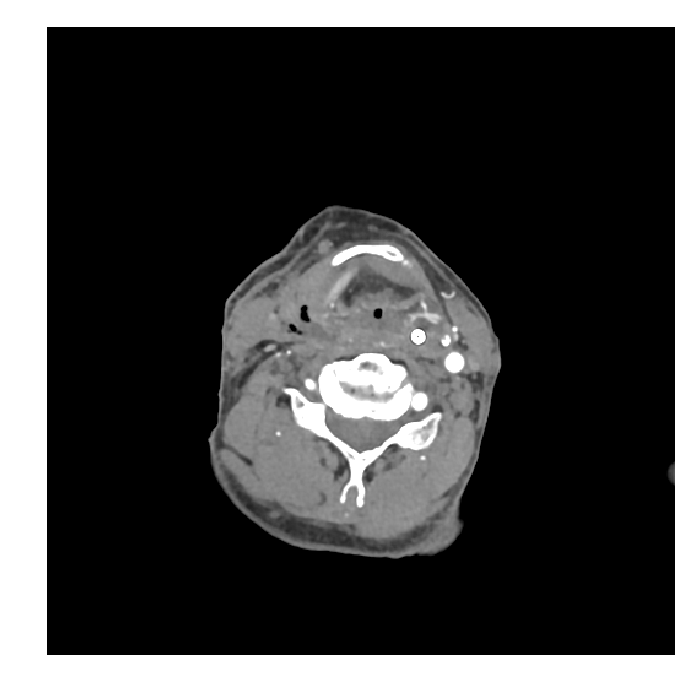

In [25]:
fig, ax = plt.subplots(figsize=(7,7))   
plt.tight_layout()

ct_extent = [dt.ct.coordinates.x.min(), dt.ct.coordinates.x.max(), dt.ct.coordinates.y.max(), dt.ct.coordinates.y.min()]
slice_idx = INITIAL_SLICE if INITIAL_SLICE is not None else ct.shape[0]//2

x, y = dt.ct.coordinates.x, dt.ct.coordinates.y

# Plot initial slice
ct_slice = ax.imshow(ct[slice_idx], cmap='gray', interpolation='none', extent=ct_extent)
structure = dt.contours[select_structures.value].data

# structure,_ = resize_to_user_resolution(structure, orig_coords, [1,1,1]) 

structure_contour = ax.contour(x,y, structure[slice_idx], levels=[0.5], colors='red')
ax.axis('off')

def update(slice_idx):
    global target_contour, structure_contour
    
    ct_slice.set_data(ct[slice_idx])
    ct_slice.set_clim(vmin=np.min(ct[slice_idx]), vmax=np.max(ct[slice_idx]))

    # # Remove previous contour lines for structure
    for coll in structure_contour.collections:
        coll.remove()
 
    structure_contour = ax.contour(x, y, structure[slice_idx], levels=[0.5], colors='red')
 
    plt.draw()

interact(update, slice_idx=IntSlider(min=0, max=ct.shape[0], step=1, value=ct.shape[0]//2));

---

In [ ]:
import nibabel as nib
import numpy as np

# Your NumPy array (replace with your actual data)
array_data = np.random.rand(64, 64, 32)  # Example: 64x64x32 array

# Create a NIfTI1Image object
nifti_image = nib.Nifti1Image(array_data, affine=np.eye(4))

# Save the image to a NIfTI file
nib.save(nifti_image, 'my_nifti_file.nii.gz') 